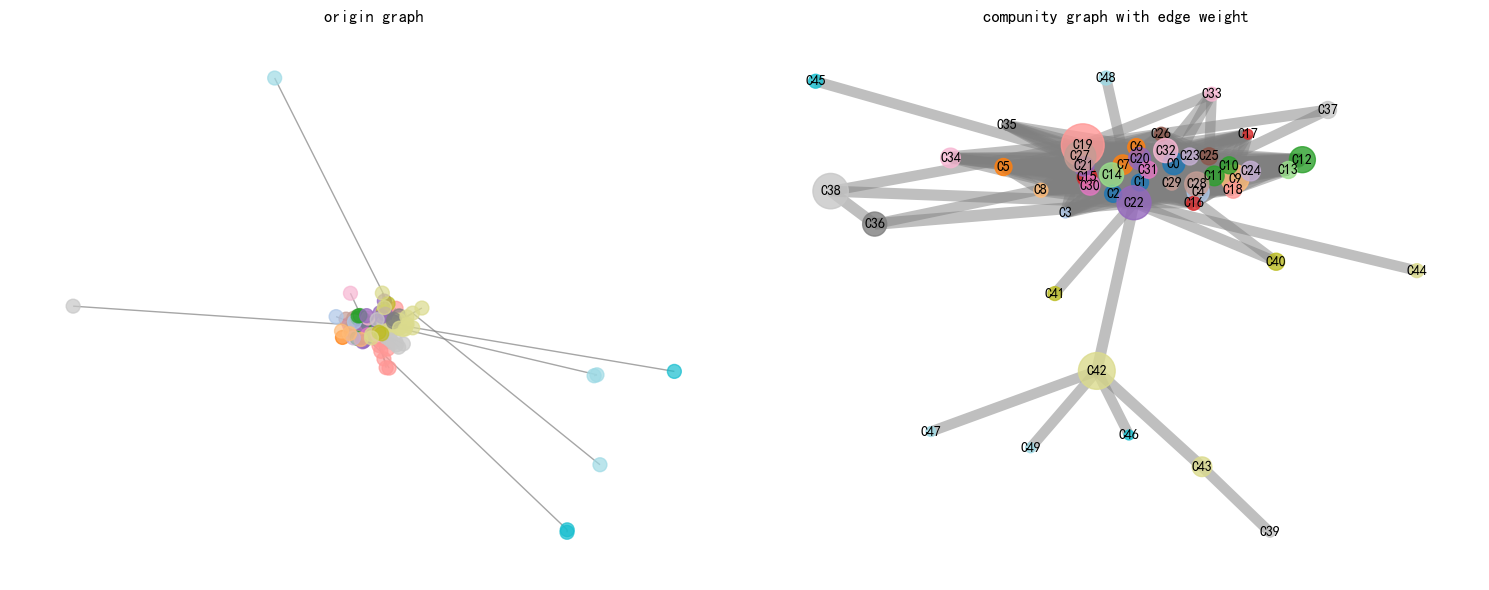

In [75]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import community



G = nx.Graph()

# data_name = "2017_美国_平均-100"
# data_name = "2017_美国_平均-150"
# data_name = "2017_美国_平均-200"
# data_name = "2017_美国_平均-250"
# data_name = "2017_美国_平均-300"
# resolution = 6

data_name = "2016_中国_平均-100"
data_name = "2016_中国_平均-150"
data_name = "2016_中国_平均-200"
data_name = "2016_中国_平均-250"
data_name = "2016_中国_平均-300"
resolution = 6

df = pd.read_csv("网络采样/" + data_name + ".csv") 
G.add_weighted_edges_from(df[["source", "target", "weight"]].values)





# G = nx.erdos_renyi_graph(100, 0.05)
GCC = max(nx.connected_components(G), key=len)
G = G.subgraph(GCC).copy()

# 使用Louvain算法检测社区
partition = community.best_partition(G, resolution=resolution)
community_g = nx.Graph()

# 添加社区节点
communities = set(partition.values())
community_g.add_nodes_from(communities)

# 遍历原始图中的所有边，构建社区间的连接
for u, v in G.edges():
    # 获取节点u和v所属的社区
    u_comm = partition[u]
    v_comm = partition[v]
    
    # 如果两个节点属于不同社区
    if u_comm != v_comm:
        # 如果边已存在，增加权重
        if community_g.has_edge(u_comm, v_comm):
            community_g[u_comm][v_comm]['weight'] += 1
        else:
            community_g.add_edge(u_comm, v_comm, weight=15)

# 现在community_g就是所需的社区图
# 每个节点代表一个社区，边代表社区间的连接，权重表示连接数量

# 可选：为社区节点添加大小属性（社区中的节点数量）
from collections import defaultdict
community_sizes = defaultdict(int)
for node, comm in partition.items():
    community_sizes[comm] += 1

nx.set_node_attributes(community_g, community_sizes, 'size')



plt.figure(figsize=(15, 6))

# 1. 绘制原始图，按社区着色
plt.subplot(121)
pos = nx.spring_layout(G, seed=42)

# 为每个社区分配一个颜色
unique_comms = set(partition.values())
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_comms)))
node_colors = [colors[partition[n]] for n in G.nodes()]

nx.draw(G, pos, node_color=node_colors, node_size=100, 
        with_labels=False, edge_color='gray', alpha=0.7)
plt.title("origin graph")

# 2. 绘制社区图
plt.subplot(122)
# 社区图布局 - 节点大小与社区大小成比例
comm_pos = nx.spring_layout(community_g, seed=42)

# 获取社区大小用于节点大小
sizes = [community_g.nodes[n]['size'] * 50 for n in community_g.nodes()]

# 绘制节点
nx.draw_networkx_nodes(community_g, comm_pos, node_size=sizes, 
                      node_color=colors, alpha=0.8)

# 绘制边 - 线宽与权重成比例
weights = [community_g[u][v]['weight'] for u, v in community_g.edges()]
nx.draw_networkx_edges(community_g, comm_pos, width=np.array(weights)/2, 
                      alpha=0.5, edge_color='gray')

# 添加社区ID标签
nx.draw_networkx_labels(community_g, comm_pos, 
                       labels={n: f"C{n}" for n in community_g.nodes()},
                       font_size=10)

plt.title("compunity graph with edge weight")
plt.axis('off')

plt.tight_layout()
plt.show()

In [76]:
community_g.edges()
len(community_g)


50

In [77]:
def topComEdge(network, community_g):
    """
    找出社区图中最重要的边（攻击后对网络连通性影响最大的边）
    
    参数:
        network: 原始网络图（NetworkX Graph对象）
        community_g: 社区图（NetworkX Graph对象），节点代表社区，边有权重
        
    返回:
        tuple: 最重要的边 (u, v)
        dict: 所有边的权重值
    """
    
    # 初始化权重字典和社区大小字典
    Weights = {}
    Sizes = {}
    
    # 步骤1-3: 计算每个社区的节点数量
    for ComNode in community_g.nodes():
        # 假设community_g的节点有'size'属性存储社区大小
        # 如果没有，我们需要计算
        if 'size' in community_g.nodes[ComNode]:
            Sizes[ComNode] = community_g.nodes[ComNode]['size']
        else:
            # 如果没有size属性，需要从原始网络和社区划分中计算
            # 这里假设network节点有'community'属性标识所属社区
            Sizes[ComNode] = sum(1 for n in network.nodes() 
                              if network.nodes[n].get('community') == ComNode)
    
    # 步骤5-7: 初始化所有边的权重为0
    for ComEdge in community_g.edges():
        Weights[ComEdge] = 0
    
    # 步骤8: 计算社区图中所有节点对的最短路径
    APSP = dict(nx.all_pairs_shortest_path(community_g))
    
    # 步骤9-16: 计算每条边的重要性权重
    for s, sp in APSP.items():  # s是源节点，sp是到其他节点的最短路径
        for t, path in sp.items():  # t是目标节点，path是最短路径
            if s == t:
                continue  # 跳过自身
            factor = Sizes[s] * Sizes[t]  # 计算因子
            # 遍历路径中的所有边
            for i in range(len(path)-1):
                e = (path[i], path[i+1]) if path[i] < path[i+1] else (path[i+1], path[i])
                Weights[e] += factor
    
    # 步骤17: 找出权重最大的边
    if not Weights:
        return None, Weights  # 如果没有边，返回None
    
    TopComEdge = max(Weights.items(), key=lambda x: x[1])[0]
    
    return TopComEdge, Weights

In [78]:
important_edge, edge_weights = topComEdge(G, community_g)

print(f"最重要的边是: {important_edge}")
print("所有边的权重:")
for edge, weight in edge_weights.items():
    print(f"边 {edge}: 权重 {weight}")

最重要的边是: (22, 42)
所有边的权重:
边 (0, 1): 权重 158
边 (0, 2): 权重 168
边 (0, 3): 权重 312
边 (0, 4): 权重 190
边 (0, 5): 权重 510
边 (0, 6): 权重 306
边 (0, 7): 权重 102
边 (0, 8): 权重 268
边 (0, 9): 权重 544
边 (0, 10): 权重 240
边 (0, 11): 权重 360
边 (0, 12): 权重 1862
边 (0, 13): 权重 660
边 (0, 14): 权重 168
边 (0, 15): 权重 200
边 (0, 16): 权重 240
边 (0, 17): 权重 284
边 (0, 18): 权重 198
边 (0, 19): 权重 2362
边 (0, 20): 权重 100
边 (0, 21): 权重 184
边 (0, 22): 权重 1840
边 (0, 23): 权重 126
边 (0, 24): 权重 352
边 (0, 25): 权重 120
边 (0, 26): 权重 368
边 (0, 27): 权重 336
边 (0, 28): 权重 144
边 (0, 29): 权重 40
边 (0, 30): 权重 304
边 (0, 31): 权重 54
边 (0, 33): 权重 656
边 (1, 9): 权重 80
边 (1, 27): 权重 75
边 (1, 28): 权重 60
边 (1, 7): 权重 27
边 (1, 25): 权重 30
边 (1, 31): 权重 30
边 (1, 4): 权重 50
边 (1, 2): 权重 18
边 (1, 3): 权重 6
边 (1, 11): 权重 24
边 (1, 14): 权重 72
边 (1, 15): 权重 24
边 (1, 16): 权重 12
边 (1, 29): 权重 21
边 (1, 10): 权重 18
边 (1, 20): 权重 30
边 (1, 30): 权重 24
边 (1, 18): 权重 18
边 (1, 32): 权重 66
边 (1, 21): 权重 24
边 (1, 22): 权重 345
边 (1, 23): 权重 18
边 (1, 24): 权重 24
边 (1, 34): 权重 144
边 (

In [79]:
def comdis(connected_G):
    """
    生成网络的攻击顺序，通过破坏社区间连接和高度节点来瓦解网络
    
    参数:
        connected_G: 连通的网络图 (NetworkX Graph对象)
        
    返回:
        list: 攻击顺序 (节点和边的移除顺序)
    """
    
    Attacks = []  # 攻击顺序集合
    GCC = connected_G.copy()  # 初始时整个网络就是最大连通组件
    Gcom = community_g.copy()
    
    # while True:
    #     # # 步骤3: 使用Louvain方法检测社区
    #     # partition = community.best_partition(GCC)
    #     # Coms = set(partition.values())  # 获取社区集合
        
    #     if len(community_g) <= 1:
    #         break  # 步骤4: 当社区数≤1时退出循环
            
        # # 步骤5: 构建社区图Gcom
        # Gcom = nx.Graph()
        # Gcom.add_nodes_from(Coms)
        
        # # 计算社区大小并添加到社区图
        # community_sizes = {comm: sum(1 for n in partition.values() if n == comm) 
        #                  for comm in Coms}
        # nx.set_node_attributes(Gcom, community_sizes, 'size')
        
        # # 添加社区间边
        # for u, v in GCC.edges():
        #     u_comm = partition[u]
        #     v_comm = partition[v]
        #     if u_comm != v_comm:
        #         if Gcom.has_edge(u_comm, v_comm):
        #             Gcom[u_comm][v_comm]['weight'] += 1
        #         else:
        #             Gcom.add_edge(u_comm, v_comm, weight=1)
        
        # 步骤6-15: 逐步移除社区图中最重要的边
    while community_g.number_of_edges() > 0:
        # 步骤7: 找出最重要的社区间边
        TopComEdge, _ = topComEdge(GCC, Gcom)
        
        if not TopComEdge:
            break
            
        # 步骤8: 获取该边连接的社区间的所有节点和边
        comm1, comm2 = TopComEdge
        # Ginter = nx.Graph()
        
        # # 添加属于这两个社区的节点
        # nodes_comm1 = [n for n in GCC.nodes() if partition[n] == comm1]
        # nodes_comm2 = [n for n in GCC.nodes() if partition[n] == comm2]
        # Ginter.add_nodes_from(nodes_comm1 + nodes_comm2)
        
        # # 添加这两个社区间的所有边
        # for u, v in GCC.edges():
        #     if (partition[u] == comm1 and partition[v] == comm2) or \
        #        (partition[u] == comm2 and partition[v] == comm1):
        #         Ginter.add_edge(u, v)
        
        # # 步骤9-13: 如果Ginter没有边(只有节点)，则按度数移除节点
        # while Ginter.number_of_edges() == 0 and Ginter.number_of_nodes() > 0:
        #     # 步骤10: 找到度数最高的节点
        #     degrees = dict(Ginter.degree())
        #     if not degrees:
        #         break
        #     v = max(degrees.items(), key=lambda x: x[1])[0]
            
        #     # 步骤11: 从Ginter和原始图中移除该节点
        #     Ginter.remove_node(v)
        #     GCC.remove_node(v)
            
        #     # 步骤12: 添加到攻击顺序
        #     Attacks.append(v)
        
        # # 步骤14: 从社区图中移除这条边
        # community_g.remove_edge(*TopComEdge)

        # 找出这两个社区之间的所有边
        inter_edges = [(u, v) for u, v in GCC.edges() 
                      if (partition[u] == comm1 and partition[v] == comm2) or
                         (partition[u] == comm2 and partition[v] == comm1)]
        
        if not inter_edges:
            Gcom.remove_edge(*TopComEdge)
            continue
            
        # 找出这些边中度数最高的节点
        max_degree = -1
        node_to_remove = None
        
        # 收集所有候选节点(这些边连接的两个社区的节点)
        candidate_nodes = set()
        for u, v in inter_edges:
            candidate_nodes.add(u)
            candidate_nodes.add(v)
        
        # 找出度数最高的节点
        degrees = GCC.degree(candidate_nodes)
        node_to_remove = max(degrees, key=lambda x: x[1])[0]
        
        # 从原图和社区图中移除该节点
        GCC.remove_node(node_to_remove)
        
        # 更新社区图 - 如果该节点是某个社区最后一个节点，需要移除该社区
        comm_of_removed = partition[node_to_remove]
        remaining_nodes_in_comm = sum(1 for n in GCC.nodes() 
                                    if partition.get(n) == comm_of_removed)
        
        if remaining_nodes_in_comm == 0:
            Gcom.remove_node(comm_of_removed)
        
        # 添加到攻击顺序
        Attacks.append(node_to_remove)
        
        # 从社区图中移除这条边(如果还存在)
        if Gcom.has_edge(comm1, comm2):
            # 更新边的权重(因为移除了节点可能减少了连接)
            remaining_edges = sum(1 for u, v in GCC.edges() 
                                if (partition.get(u) == comm1 and partition.get(v) == comm2) or
                                   (partition.get(u) == comm2 and partition.get(v) == comm1))
            
            if remaining_edges == 0:
                Gcom.remove_edge(comm1, comm2)
            else:
                Gcom[comm1][comm2]['weight'] = remaining_edges
    
    # 步骤17-18: 处理剩余节点，按度数排序后加入攻击顺序
    if GCC.number_of_nodes() > 0:
        degrees = dict(GCC.degree())
        Remains = sorted(degrees.keys(), key=lambda x: degrees[x], reverse=True)
        Attacks.extend(Remains)
    
    return Attacks

In [ ]:
attack_order = comdis(G)

print("攻击顺序(前20个):", attack_order[:20])
print("总攻击次数:", len(attack_order))

import csv


# 写入CSV文件
with open("COMDis采样攻击顺序/" + data_name + '-COMDis-r6.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # 将列表中的每个元素作为单独的行写入
    for item in attack_order:
        writer.writerow([item])  # 注意将元素放入列表中，使其成为一行一列


攻击顺序(前20个): ['ICN', 'SIN', 'FRA', 'PEK', 'MUC', 'SVO', 'CSX', 'BKK', 'XMN', 'CGQ', 'HAK', 'SHE', 'SZX', 'XIY', 'TSN', 'SGN', 'CGO', 'KBV', 'SJW', 'HRB']
总攻击次数: 215


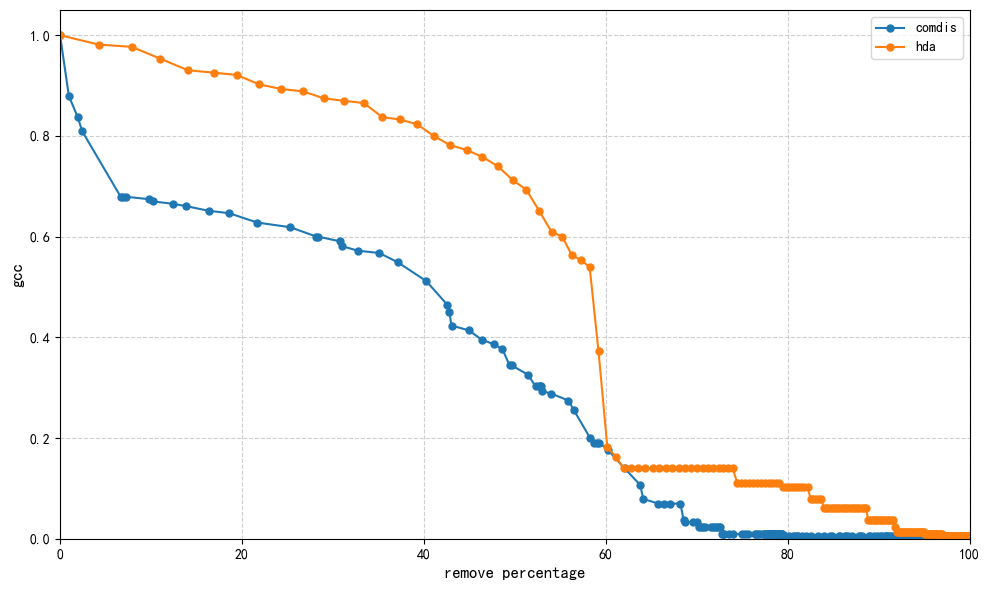

In [81]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows 系统常用字体
plt.rcParams['axes.unicode_minus'] = False

# 准备绘图数据
n_nodes = len(G)
gcc_sizes = []
removed_percent = []

# 复制原始图用于模拟攻击过程
G_attacked = G.copy()

# 记录初始状态(0%移除时)
gcc_sizes.append(len(max(nx.connected_components(G_attacked), key=len)) / n_nodes)
removed_percent.append(0.0)

# 模拟逐步移除节点并记录GCC大小
# for i, node in enumerate(attack_order, 1):
#     if node in G_attacked.nodes():
#         G_attacked.remove_node(node)
#         current_gcc = len(max(nx.connected_components(G_attacked), key=len)) if nx.number_of_nodes(G_attacked) > 0 else 0
#         # gcc_sizes.append(current_gcc / n_nodes)
#         # removed_percent.append(i / n_nodes * 100)
#         gcc_sizes.append(current_gcc / len(GCC))
#         removed_percent.append(i / n_nodes * 100)

remove_cost = 0
sum_degrees = sum(dict(G.degree()).values())
for node in attack_order:
    if node in G_attacked.nodes():
        G_attacked.remove_node(node)
        current_gcc = len(max(nx.connected_components(G_attacked), key=len)) if nx.number_of_nodes(G_attacked) > 0 else 0
        # gcc_sizes.append(current_gcc / n_nodes)
        # removed_percent.append(i / n_nodes * 100)
        gcc_sizes.append(current_gcc / len(GCC))
        remove_cost += G.degree(node)
        removed_percent.append(remove_cost * 100/sum_degrees)

# 绘制结果
plt.figure(figsize=(10, 6))
plt.plot(removed_percent, gcc_sizes, marker='o', markersize=5, label='comdis')

def HXA(g, method):
    G_1 = g.copy()
    if method == 'HDA':
        dc = nx.degree_centrality(G_1)
    elif method == 'HBA':
        dc = nx.betweenness_centrality(G_1)
    elif method == 'HCA':
        dc = nx.closeness_centrality(G_1)
    elif method == 'HPRA':
        dc = nx.pagerank(G_1)

    # 按中心性排序节点（降序），并仅保留节点名称
    sol = sorted(dc.keys(), key=lambda x: dc[x], reverse=True)

    n_nodes = len(G_1)
    gcc_sizes = []
    removed_percent = []
    gcc_sizes.append(len(max(nx.connected_components(G_1), key=len)) / n_nodes)
    removed_percent.append(0.0)

    # for i, node in enumerate(sol, 1):
    #     if G_1.has_node(node):  # 确认节点存在
    #         G_1.remove_node(node)
    #         current_gcc = len(max(nx.connected_components(G_1), key=len)) if nx.number_of_nodes(G_1) > 0 else 0
    #         gcc_sizes.append(current_gcc / n_nodes)
    #         removed_percent.append(i / n_nodes * 100)

    remove_cost_hxa = 0

    for i, node in enumerate(sol, 1):
        if G_1.has_node(node):  # 确认节点存在
            G_1.remove_node(node)
            current_gcc = len(max(nx.connected_components(G_1), key=len)) if nx.number_of_nodes(G_1) > 0 else 0
            # gcc_sizes.append(current_gcc / n_nodes)
            # removed_percent.append(i / n_nodes * 100)
            gcc_sizes.append(current_gcc / len(GCC))
            remove_cost_hxa += G.degree(node)
            removed_percent.append(remove_cost_hxa * 100/sum_degrees)
    
    return removed_percent, gcc_sizes
plt.plot(HXA(G, 'HDA')[0], HXA(G, 'HDA')[1], marker='o', markersize=5, label='hda')


# # 添加关键点标记
# plt.axvline(x=100*len(attack_order)/n_nodes, color='r', linestyle='--', alpha=0.5, label='attack complete')

# 设置图形属性
plt.xlabel('remove percentage', fontsize=12)
plt.ylabel('gcc', fontsize=12)
# plt.title(data_name + "-comdis Resolution=1.5", fontsize=14) #####################################
# plt.title(data_name + "-comdis", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)
plt.xlim(0, 100)
plt.ylim(0, 1.05)

# # 突出显示关键区域
# plt.fill_between(removed_percent, gcc_sizes, 0, color='blue', alpha=0.1)

# plt.savefig(
#     data_name + "-comdis Resolution=1.5" + ".png", #######################################
#     dpi=300,
#     bbox_inches='tight',
#     transparent=False
# )


plt.tight_layout()
plt.show()